# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px ## Imported Plotly to get more
import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression,Ridge, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score ,mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV

In [6]:
# reading the files and understanding the data
vehicles = pd.read_csv('sample_data/vehicles.csv')
vehicles # total 426880 records

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111454,7316693540,south florida,14988,2013.0,bmw,3 series,excellent,NaN,gas,70834.0,clean,automatic,WBA3B5C58DJ598881,4wd,NaN,sedan,grey,fl
111455,7316691167,south florida,27000,2013.0,jeep,wrangler,NaN,NaN,gas,69000.0,clean,manual,NaN,NaN,NaN,NaN,NaN,fl
111456,7316688962,south florida,2200,2001.0,toyota,corolla s,NaN,NaN,gas,180000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,fl
111457,7316688821,south florida,50000,2014.0,chevrolet,corvette,like new,8 cylinders,gas,33243.0,clean,automatic,1G1YK2D71E5113457,rwd,compact,hatchback,white,fl


**Definition**:

We are attempting to predict the price of a user's car from a given dataset to assist the client (a car dealership) with their inventory and sales.

We will try to answer the following questions:
1) Which factors most strongly affect the resale price of the car?
2) Is customer value certain attributes (features) more than others?
3) How does age and mileage increase or decrease the value?
4) Are there categories like model or transmission that sell for higher prices?

# Success Criteria:

* Identify key predictors of price with supporting visualizations
* Provide recommendations to the dealership.



### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [7]:
# vehicles.shape is giving 426880,18 columns
vehicles.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111459 entries, 0 to 111458
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            111459 non-null  int64  
 1   region        111459 non-null  object 
 2   price         111459 non-null  int64  
 3   year          111022 non-null  float64
 4   manufacturer  106526 non-null  object 
 5   model         110033 non-null  object 
 6   condition     68009 non-null   object 
 7   cylinders     66219 non-null   object 
 8   fuel          110781 non-null  object 
 9   odometer      109821 non-null  float64
 10  title_status  109056 non-null  object 
 11  transmission  110859 non-null  object 
 12  VIN           71318 non-null   object 
 13  drive         77430 non-null   object 
 14  size          31684 non-null   object 
 15  type          89626 non-null   object 
 16  paint_color   78399 non-null   object 
 17  state         111458 non-null  object 
dtypes: f

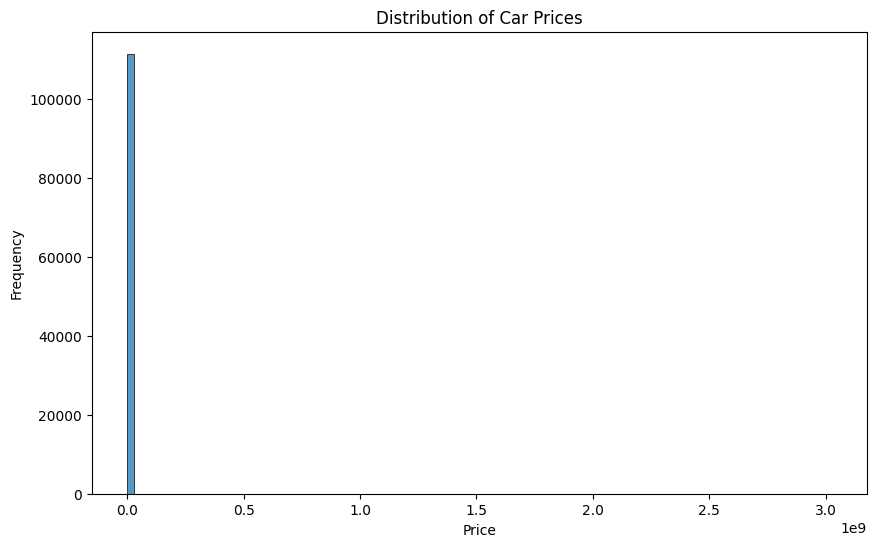

In [8]:
# checking the price distribution
plt.figure(figsize=(10, 6))
sns.histplot(vehicles['price'].dropna(), bins=100)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


The above distribution is completely squashed because some cars are listed at hundreds of thousands. So I am trying the capping values at the 99th percentile.

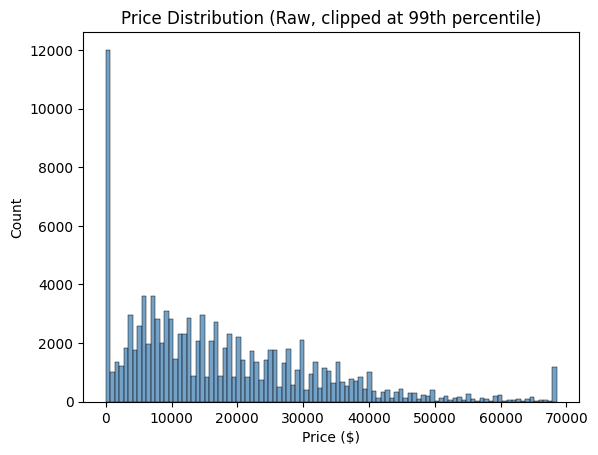

In [9]:
# Raw price distribution with 99 the percentile
sns.histplot(vehicles["price"].dropna().clip(upper=vehicles["price"].quantile(0.99)), bins=100, color="steelblue")
plt.title("Price Distribution (Raw, clipped at 99th percentile)")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.show()
# this distribution showed the data is skewed. So to normalize we can try log1p for modeling.

This distribution showed that the data is skewed. To normalize, we can try log1p for modeling, since car prices are non-negative.

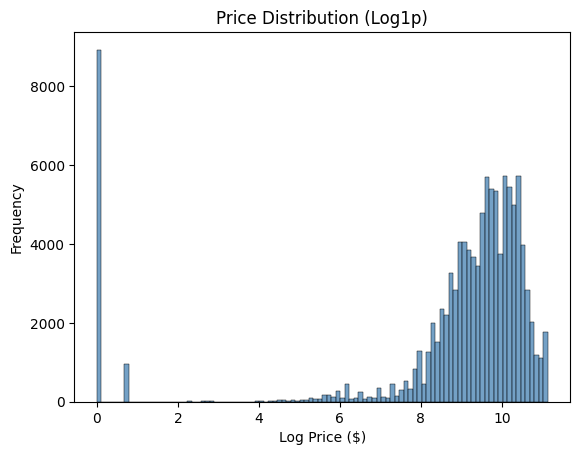

In [10]:
sns.histplot(np.log1p(vehicles["price"].dropna().clip(upper=vehicles["price"].quantile(0.99))), bins=100, color="steelblue")
plt.title("Price Distribution (Log1p)")
plt.xlabel("Log Price ($)")
plt.ylabel("Frequency")
plt.show()

**Understand the relationship between year and price.**

We will derive the age of the car by the present year in the vehicle's data.



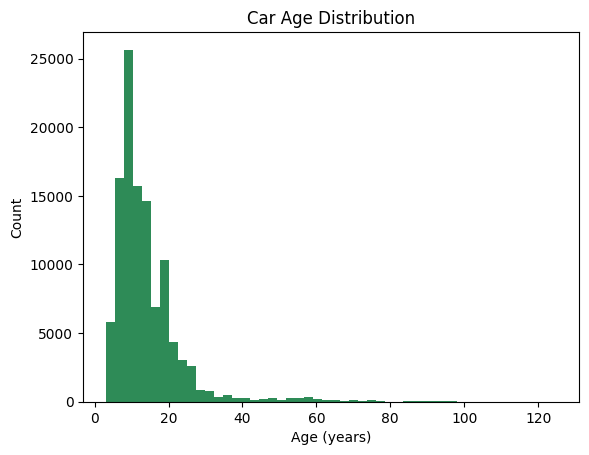

In [11]:
# this plot not giving age so lets derive a new column called age = prasent year - year
current_year = datetime.datetime.now().year
vehicles["age"] = current_year - pd.to_numeric(vehicles["year"], errors="coerce")
plt.hist(vehicles["age"].dropna(), bins=50, color="seagreen")
plt.title("Car Age Distribution")
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.show()

## Most cars are between 5-20 years old

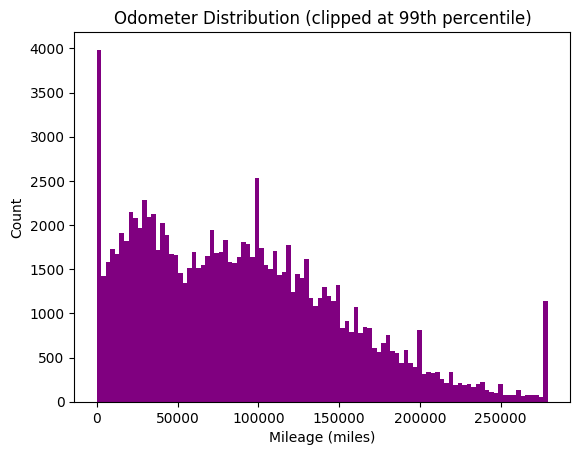

In [12]:
#histogram for odometer raiting
plt.hist(vehicles["odometer"].dropna().clip(upper=vehicles["odometer"].quantile(0.99)), bins=100, color="purple")
plt.title("Odometer Distribution (clipped at 99th percentile)")
plt.xlabel("Mileage (miles)")
plt.ylabel("Count")
plt.show()

## Mileage is right-skewed; most cars have under 200,000 miles

<Axes: xlabel='odometer', ylabel='price'>

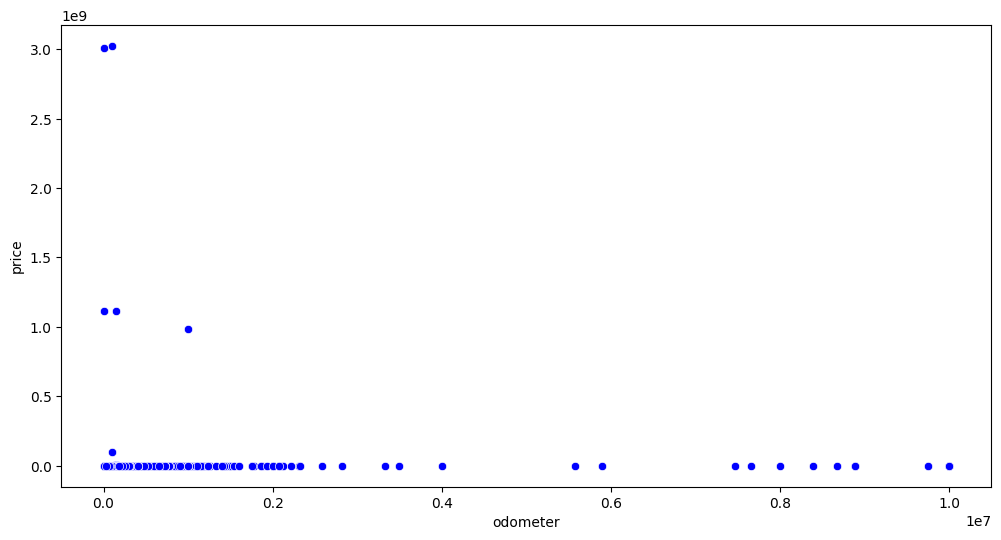

In [13]:
# Understanding the relationship between odometer & price and mileage & price
plt.figure(figsize=(12, 6))
sns.scatterplot(data=vehicles, x="odometer", y="price", color="blue")


Text(0, 0.5, 'Price ($)')

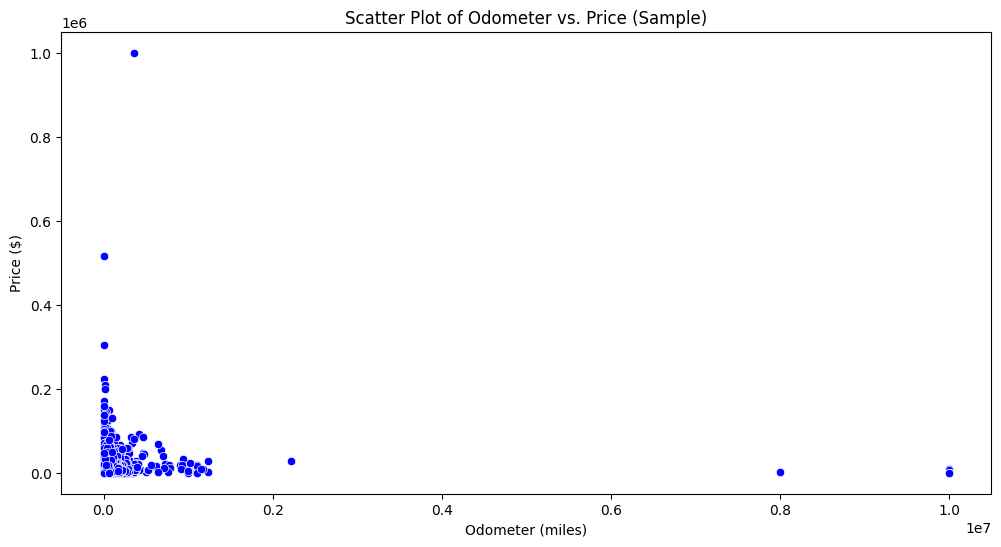

In [14]:
# Above scatter plot didn't gave much information and its hard to understand due to outlairs
# we are going to take sample of 5000 records and see how this shows
sample_size = 20000
vehicles_sample = vehicles.sample(n=sample_size, random_state=42)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=vehicles_sample, x="odometer", y="price", color="blue")
plt.title("Scatter Plot of Odometer vs. Price (Sample)")
plt.xlabel("Odometer (miles)")
plt.ylabel("Price ($)")

Text(0, 0.5, 'Price ($)')

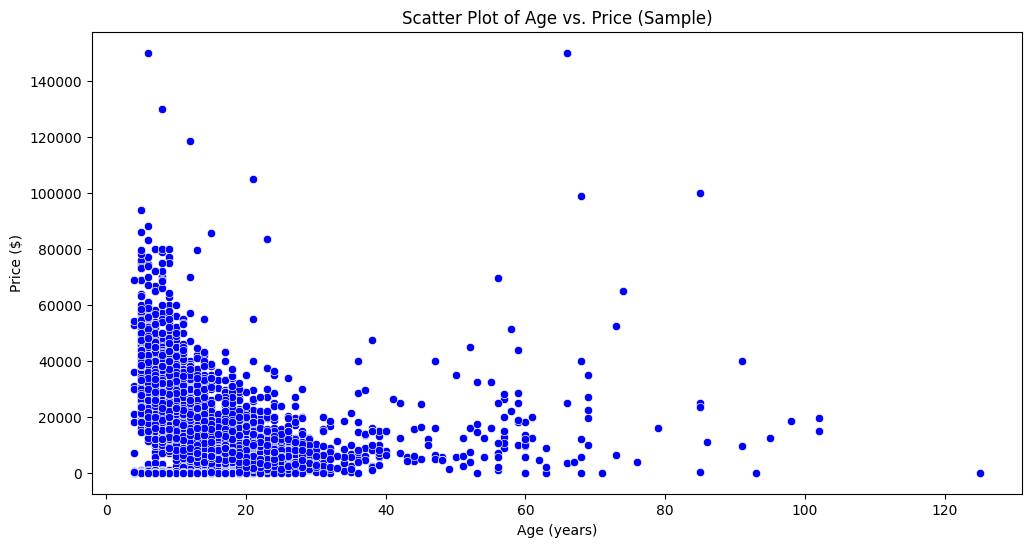

In [15]:
# Above scatter plot didn't gave much information and its hard to understand due to outlairs
# we are going to take sample of 5000 records and see how this shows
sample_size = 5000
vehicles_sample = vehicles.sample(n=sample_size, random_state=42)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=vehicles_sample, x="age", y="price", color="blue")
plt.title("Scatter Plot of Age vs. Price (Sample)")
plt.xlabel("Age (years)")
plt.ylabel("Price ($)")


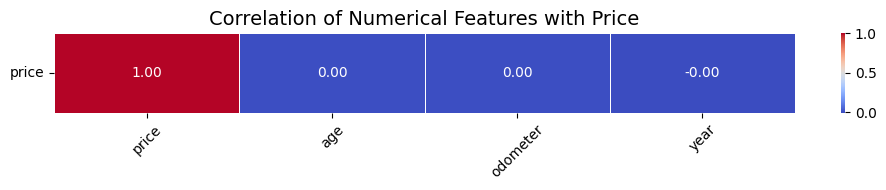

In [16]:
# we dont want to use id, VIN and
vehicles = vehicles.drop(columns=['id', 'VIN'])

# Compute correlation of all numerical columns with 'price'
price_corr = vehicles.corr(numeric_only=True)['price'].sort_values(ascending=False)

# Convert to DataFrame for heatmap
price_corr_df = price_corr.to_frame().T  # transpose to make a row for heatmap

# Plot heatmap
plt.figure(figsize=(10, 2))  # shorter height since only one row
sns.heatmap(
    price_corr_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5
)

plt.title("Correlation of Numerical Features with Price", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## What we learned

1) Price decreases as the age increases
2) Price decreases as the mileage increases

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [17]:
# Identify columns with missing values
# Same logic as practical assignment 1
null_columns = vehicles.columns[vehicles.isnull().any()].tolist()
print("Columns with null values:")
print(null_columns)

null_counts = vehicles[null_columns].isnull().sum()
print("\nTotal null values in each column:")
print(null_counts)

Columns with null values:
['year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state', 'age']

Total null values in each column:
year              437
manufacturer     4933
model            1426
condition       43450
cylinders       45240
fuel              678
odometer         1638
title_status     2403
transmission      600
drive           34029
size            79775
type            21833
paint_color     33060
state               1
age               437
dtype: int64


In [18]:
## Remove the missing/invalid price like price less than 0
vehicles = vehicles[vehicles['price'] > 0]
# dropping the nulls in the price, age, odometer readings
# whithout these features we utilize
vehicles = vehicles.dropna(subset=['price', 'age', 'odometer'])

# Clean odometer if present
vehicles["odometer"] = pd.to_numeric(vehicles["odometer"], errors="coerce")

# Clip extreme outliers for EDA (not permanently removing; just for visuals)
price_99 = vehicles["price"].quantile(0.99)
print("99th percentile price:", price_99)
vehicles

99th percentile price: 68777.0


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,age
27,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,NaN,NaN,pickup,white,al,11.0
28,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,NaN,NaN,pickup,blue,al,15.0
29,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,NaN,NaN,pickup,red,al,5.0
30,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,NaN,NaN,pickup,red,al,8.0
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111453,south florida,14988,2014.0,bmw,5 series,excellent,NaN,gas,98560.0,clean,automatic,rwd,NaN,sedan,white,fl,11.0
111454,south florida,14988,2013.0,bmw,3 series,excellent,NaN,gas,70834.0,clean,automatic,4wd,NaN,sedan,grey,fl,12.0
111455,south florida,27000,2013.0,jeep,wrangler,NaN,NaN,gas,69000.0,clean,manual,NaN,NaN,NaN,NaN,fl,12.0
111456,south florida,2200,2001.0,toyota,corolla s,NaN,NaN,gas,180000.0,clean,automatic,NaN,NaN,NaN,NaN,fl,24.0


We updated the price, age, and odometer information as mentioned above. The next step is to split the Train and Test data. This was recommended at this stage to avoid leakage.

In [19]:
# Create target price to log-space since price is skewed
vehicles['log_price'] = np.log1p(vehicles['price'])

#Random split (70, 30)
train_df, test_df = train_test_split(vehicles, test_size=0.3, random_state=42)
print("Train rows:", train_df.shape[0], "Test rows:", test_df.shape[0])

Train rows: 70719 Test rows: 30309


**Features & Categorical variables**

Numeric Features: age, odometer

Categorical: condition, fuel, transmission, title_status, region, manufacture

We are going to use One Hot encoding that is best for fewer unique values for columns condition, fuel, transmission, title_status & region, but for manufacturer and model, we need to use Frequency encoding ( and Target encoding)

In [20]:
numeric_features = ["age", "odometer"]

low_card_cat = ["condition","fuel","transmission","title_status","type"]
high_card_cat = ["manufacturer","model","region"]

# Frequency encoding for high - cardinality field
# Defining the function to accept train_series & test_series and append frequency
def freq_encode(train_series, test_series):
    freq = train_series.value_counts(normalize=True)
    # Map to frequency; unseen -> 0
    return train_series.map(freq).fillna(0), test_series.map(freq).fillna(0)
# Frequency encoding for manufacturer
tr_man_freq, te_man_freq = freq_encode(train_df["manufacturer"], test_df["manufacturer"])
train_df["manufacturer_freq"] = tr_man_freq
test_df["manufacturer_freq"] = te_man_freq
# Frequency encoding for model
tr_man_freq, te_man_freq = freq_encode(train_df["model"], test_df["model"])
train_df["model_freq"] = tr_man_freq
test_df["model_freq"] = te_man_freq
# Frequency encoding for region
tr_man_freq, te_man_freq = freq_encode(train_df["region"], test_df["region"])
train_df["region_freq"] = tr_man_freq
test_df["region_freq"] = te_man_freq
## adding manufacturer_freq and model_freq to numeric_features
numeric_features.extend(["manufacturer_freq", "model_freq","region_freq"])
numeric_features

['age', 'odometer', 'manufacturer_freq', 'model_freq', 'region_freq']

In [21]:
#creating pipeline for tranforming the numerical features
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), ## - fill in the missing values with median
    ("poly", PolynomialFeatures(degree=2, include_bias=False)), ## - porlynomial features
    ('scaler', StandardScaler())
])
#creating pipeline for tranforming the numerical features without PolynomialFeatures
numeric_transformer_non_poly = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
#creating pipeline for transforming the categorical features
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")) # Use OneHotEncoder here
])

#preprocessor for columntranformation
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, low_card_cat)
    ]
, remainder="drop")
#preprocessor for columntranformation without PolynomialFeatures
preprocessor_non_poly = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_non_poly, numeric_features),
        ("cat", categorical_transformer, low_card_cat)
    ]
, remainder="drop")

# Feature selection with Lasso
Below are the features selected


*   age
*   odometer
*   manufacturer
*   model
*   fuel
*   type
*   condition






Top 15 features by Lasso coefficient magnitude:
num__age                       -0.849088
cat__condition_fair            -0.764110
num__age^2                      0.631194
cat__condition_salvage         -0.613811
cat__title_status_parts only   -0.586710
cat__type_wagon                -0.496493
cat__fuel_diesel                0.480520
num__odometer                  -0.463802
cat__type_pickup                0.399728
num__odometer^2                 0.358717
cat__title_status_lien          0.353042
cat__title_status_clean         0.350420
cat__type_hatchback            -0.329184
cat__type_offroad               0.307381
cat__type_missing              -0.301813
cat__type_sedan                -0.295808
cat__type_convertible           0.268100
cat__type_mini-van             -0.266647
num__model_freq                -0.259580
cat__fuel_hybrid               -0.222677
dtype: float64


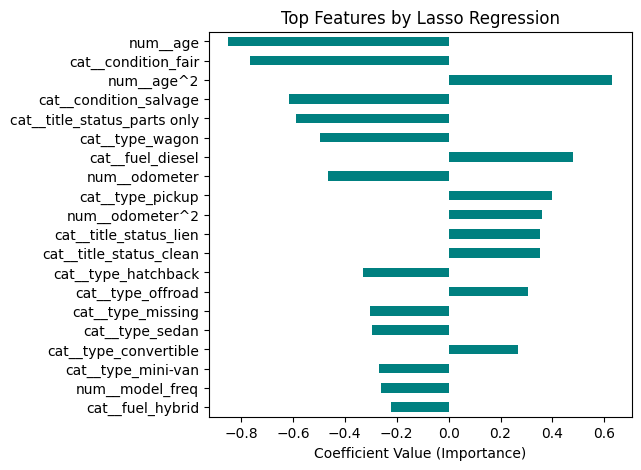

In [22]:
# --- Lasso (embedded feature selection) ---
feature_names = numeric_features + low_card_cat
X = train_df[feature_names]
y = train_df["log_price"]

lasso = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LassoCV(cv=5, random_state=42))
])
lasso.fit(X, y)

# Get feature names after preprocessing
preprocessed_feature_names = preprocessor.get_feature_names_out(feature_names)
coef = lasso.named_steps["model"].coef_

lasso_selected = pd.Series(coef, index=preprocessed_feature_names)
lasso_top = lasso_selected[lasso_selected != 0].sort_values(key=abs, ascending=False).head(20)

print("\nTop 15 features by Lasso coefficient magnitude:")
print(lasso_top)

# --- Visualization ---
plt.figure(figsize=(12, 5))

# Lasso plot
plt.subplot(1, 2, 1)
lasso_top.plot(kind="barh", color="teal")
plt.title("Top Features by Lasso Regression")
plt.xlabel("Coefficient Value (Importance)")
plt.gca().invert_yaxis()

In [23]:
# numeric_features and low_card_cat are already defined and contain the features selected by Lasso
# We will use these features for modeling

# The combined list of features to be used for modeling
features_for_modeling = numeric_features + low_card_cat

# Print the list of features to be used for modeling
print("Features used for modeling:")
print(features_for_modeling)

Features used for modeling:
['age', 'odometer', 'manufacturer_freq', 'model_freq', 'region_freq', 'condition', 'fuel', 'transmission', 'title_status', 'type']


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

# Modeling and pipelines
I am going to use the two models below
* Linear Regression
*  Ridge Regression

I also attempted to run Random Forest, but it took a long time to execute, so I used sample data to gain some insight.

In [24]:
# Define three models
feature_selector = SelectFromModel(LassoCV(cv=5, random_state=42))
# Linear pipeline
liner_pipe = Pipeline(steps=[
    ("preproc", preprocessor),
    ("select_features", feature_selector),
    ("Linear", LinearRegression())
])
# Ridge pipeline
ridge_pipe = Pipeline(steps=[
    ("preproc", preprocessor),
    ("select_features", feature_selector),
    ##("poly", PolynomialFeatures(degree=2, include_bias=False)),  # NEW STEP
    ("ridge", Ridge(random_state=42))
])


# Prepare training matrices
X_train = train_df[features_for_modeling]
y_train = train_df["log_price"]
X_test = test_df[features_for_modeling]
y_test = test_df["log_price"]

# Fit Ridge
ridge_pipe.fit(X_train, y_train)
y_pred_ridge = ridge_pipe.predict(X_test)

# Fit Linear
liner_pipe.fit(X_train, y_train)
y_pred_linear = liner_pipe.predict(X_test)

# Metrics helper
def print_metrics(y_true_log, y_pred_log, label="model"):
    # log-space metrics
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    r2_log = r2_score(y_true_log, y_pred_log)
    # convert to dollar-space
    y_true_d = np.expm1(y_true_log)
    y_pred_d = np.expm1(y_pred_log)
    rmse_dollars = np.sqrt(mean_squared_error(y_true_d, y_pred_d))
    mae_dollars = mean_absolute_error(y_true_d, y_pred_d)
    print(f"{label} | RMSE(log)={rmse_log:.5f}  R2(log)={r2_log:.5f}  RMSE($)={rmse_dollars:,.5f}  MAE($)={mae_dollars:,.5f}")

print_metrics(y_test, y_pred_ridge, label="Ridge")
print_metrics(y_test, y_pred_linear, label="linear")

Ridge | RMSE(log)=1.14272  R2(log)=0.23607  RMSE($)=17,286,712.63838  MAE($)=106,959.16739
linear | RMSE(log)=1.14271  R2(log)=0.23607  RMSE($)=17,286,712.64968  MAE($)=106,959.42390


# Feature importance
Both linear and ridge models yield the same RMSE of 1.08702, with a $ value of 17,273,318.98107, without polynomial features.
Once you add polynomial features, the RMSE is reduced to 1.00329.


In [25]:
# Get selected features mask
selected_mask = ridge_pipe.named_steps["select_features"].get_support()

# Apply preprocessor to X_train to get feature names after transformation
X_train_preprocessed = ridge_pipe.named_steps["preproc"].transform(X_train)
# Get feature names after preprocessing
preprocessed_feature_names = ridge_pipe.named_steps["preproc"].get_feature_names_out(features_for_modeling)

# Use the mask to select the preprocessed feature names
selected_features = preprocessed_feature_names[selected_mask]

# Get Ridge coefficients from the fitted model
ridge_coefs = ridge_pipe.named_steps["ridge"].coef_

# Build a summary table using pandas

ridge_coefs_df = pd.DataFrame({
    "Feature": selected_features,
    "Ridge Coef": ridge_coefs
}).sort_values("Ridge Coef", key=lambda x: x.abs(), ascending=False)

# Print the DataFrame
print("\nRidge Model Feature Coefficients:")
print(ridge_coefs_df)


Ridge Model Feature Coefficients:
                               Feature  Ridge Coef
35        cat__title_status_parts only   -1.108945
0                             num__age   -0.858623
20                 cat__condition_fair   -0.775212
24              cat__condition_salvage   -0.738974
5                           num__age^2    0.637525
33              cat__title_status_lien    0.511335
25                    cat__fuel_diesel    0.487914
45                   cat__type_offroad    0.474529
1                        num__odometer   -0.473913
51                     cat__type_wagon   -0.463755
47                    cat__type_pickup    0.442526
32             cat__title_status_clean    0.406646
10                     num__odometer^2    0.359558
40               cat__type_convertible    0.324755
42                 cat__type_hatchback   -0.292264
39                       cat__type_bus   -0.285621
3                      num__model_freq   -0.277913
44                   cat__type_missing   -0.260

<Axes: xlabel='Feature'>

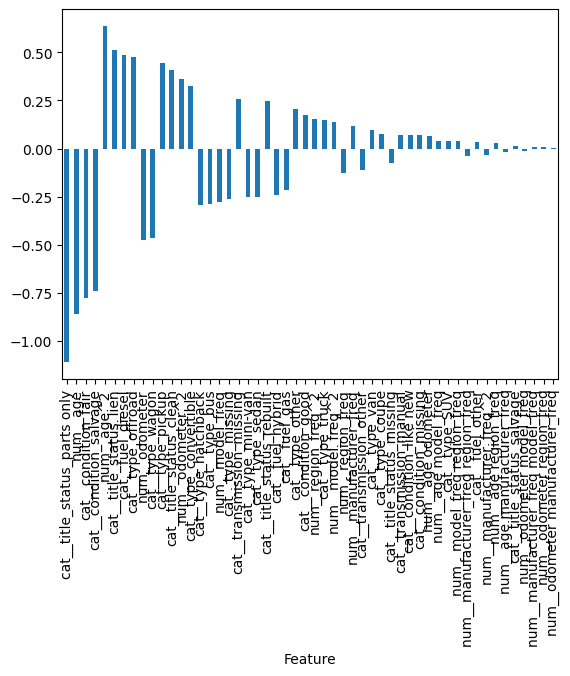

In [26]:
ridge_coefs_df.set_index("Feature")["Ridge Coef"].plot.bar()


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [27]:
param_grid = {"ridge__alpha": [0.1, 1.0, 10.0, 100.0]}
param_grid = {"ridge__alpha": np.logspace(-3, 3, 10)}
gs_ridge = GridSearchCV(ridge_pipe, param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
gs_ridge.fit(X_train, y_train)
print("Best Ridge params:", gs_ridge.best_params_)
print("Best CV score (neg MSE):", gs_ridge.best_score_)


Best Ridge params: {'ridge__alpha': np.float64(10.0)}
Best CV score (neg MSE): -1.3737756619548749


In [28]:
best_ridge = gs_ridge.best_estimator_

y_pred_train = best_ridge.predict(X_train)
y_pred_test  = best_ridge.predict(X_test)

print_metrics(y_train, y_pred_train, label="Ridge (Train)")
print_metrics(y_test, y_pred_test, label="Ridge (Test)")

Ridge (Train) | RMSE(log)=1.17082  R2(log)=0.22325  RMSE($)=13,350,589.04300  MAE($)=97,496.92447
Ridge (Test) | RMSE(log)=1.14277  R2(log)=0.23600  RMSE($)=17,286,712.54579  MAE($)=106,957.12972


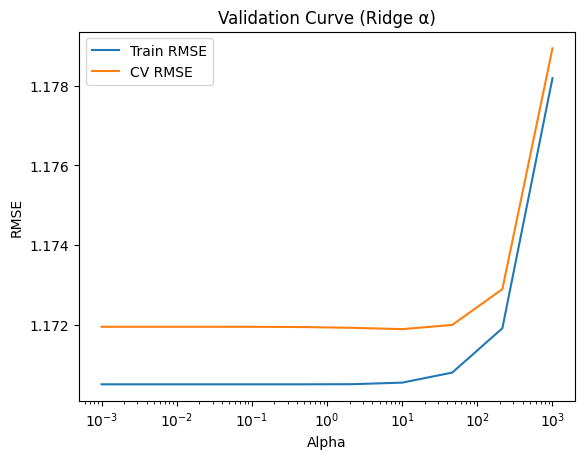

In [29]:
from sklearn.model_selection import validation_curve

alphas = np.logspace(-3, 3, 10)
train_scores, val_scores = validation_curve(
    ridge_pipe, X_train, y_train,
    param_name="ridge__alpha", param_range=alphas,
    cv=3, scoring="neg_root_mean_squared_error"
)

plt.plot(alphas, -train_scores.mean(axis=1), label="Train RMSE")
plt.plot(alphas, -val_scores.mean(axis=1), label="CV RMSE")
plt.xscale("log"); plt.xlabel("Alpha"); plt.ylabel("RMSE")
plt.title("Validation Curve (Ridge α)")
plt.legend(); plt.show()

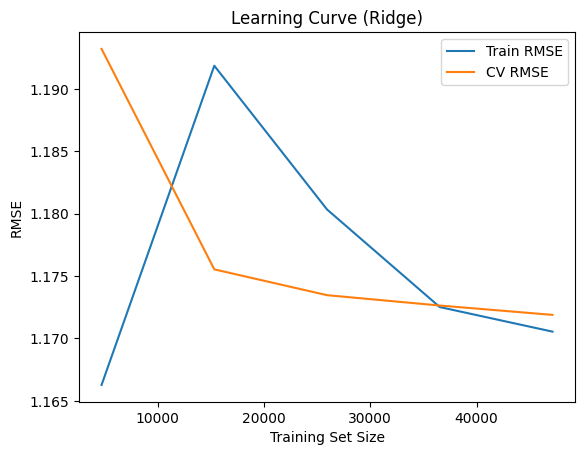

In [30]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_ridge, X_train, y_train,
    cv=3, scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

plt.plot(train_sizes, -train_scores.mean(axis=1), label="Train RMSE")
plt.plot(train_sizes, -val_scores.mean(axis=1), label="CV RMSE")
plt.xlabel("Training Set Size"); plt.ylabel("RMSE")
plt.title("Learning Curve (Ridge)")
plt.legend(); plt.show()

# Ridge (linear) Results

Ridge (Train) | RMSE(log)=1.04314  R2(log)=0.28370  RMSE(Dollar)=10,190,543.30683  MAE(Dollar)=52,258.62890
Ridge (Test) | RMSE(log)=1.03882  R2(log)=0.28533  RMSE(Dollar)=17,273,318.56565  MAE(Dollar)=113,090.18294

Both train & test errors are large and similar
The model is too simple (linear olny) for complex dataset given
The case is underfitting since high bias and low variance.

# Trying to use Random Forest Regressor

*   Using same approach as Ridge but using preprocessor_non_poly since Random Forest Regressor is non linear so dont need polynomial functions.



In [31]:

# ----------------------------------------
# Random Forest pipeline for nonlinear functions
# ----------------------------------------
rf_pipe = Pipeline(steps=[
    ("preproc", preprocessor_non_poly),   # same preprocessor without poly on numeric + OHE for cat
    ("select_features", SelectFromModel(LassoCV(cv=5, random_state=42))),  # same feature selection
    ("rf", RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        n_jobs=-1,
        random_state=42
    ))
])

# Train
rf_pipe.fit(X_train, y_train)

# Predictions
y_pred_rf_train = rf_pipe.predict(X_train)
y_pred_rf_test  = rf_pipe.predict(X_test)

# Evaluate
print_metrics(y_train, y_pred_rf_train, label="RandomForest (Train)")
print_metrics(y_test, y_pred_rf_test, label="RandomForest (Test)")



RandomForest (Train) | RMSE(log)=0.87760  R2(log)=0.56359  RMSE($)=13,348,967.72727  MAE($)=95,756.61837
RandomForest (Test) | RMSE(log)=0.93052  R2(log)=0.49345  RMSE($)=17,286,533.21542  MAE($)=105,527.38230


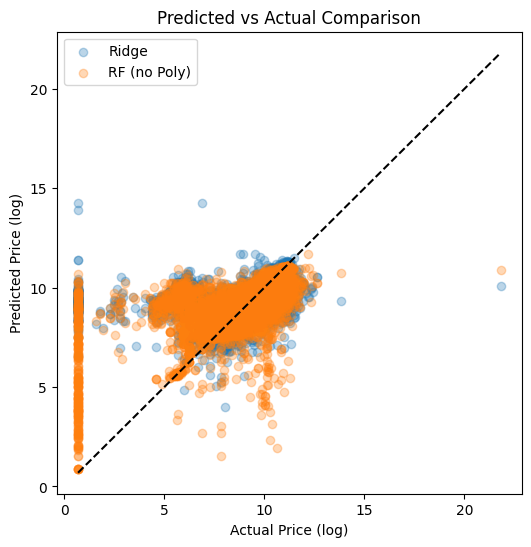

In [32]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_ridge, alpha=0.3, label="Ridge")
#plt.scatter(y_test, y_pred_rf_test, alpha=0.3, label="RF+Poly")
plt.scatter(y_test, y_pred_rf_test, alpha=0.3, label="RF (no Poly)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--') # ideal line
plt.xlabel("Actual Price (log)")
plt.ylabel("Predicted Price (log)")
plt.legend()
plt.title("Predicted vs Actual Comparison")
plt.show()

# RandomForest (non-linear) Results

RandomForest (Train) | RMSE(log)=0.90007  R2(log)=0.46672  RMSE($)=10,189,144.16438  MAE($)=50,984.37436
RandomForest (Test) | RMSE(log)=0.93228  R2(log)=0.42440  RMSE($)=17,273,300.88980  MAE($)=111,972.67867

* Train vs Test gap still small → no overfit

* Test score modestly improved over Ridge and RF+Poly.

* So this is less underfit than Ridge, but still not “good enough” (R² ~0.42 is low).

** Next Step: RandomizedSearchCV To fine tune the RandomForest parameters **

RandomForest (Train) | RMSE(log)=0.36602  R2(log)=0.91181  RMSE($)=10,178,913.15868  MAE($)=46,263.82436


RandomForest (Test) | RMSE(log)=0.74941  R2(log)=0.62806  RMSE($)=17,273,262.88385  MAE($)=109,129.00073

In [33]:
# Subsample training data for tuning
X_train_sample = X_train.sample(n=5000, random_state=42)  # pick 5000 rows - since its taking long time to run this with all data.
y_train_sample = y_train.loc[X_train_sample.index]

print("Original training size:", X_train.shape[0])
print("Sampled training size:", X_train_sample.shape[0])

# Define search space
param_dist = {
    "rf__n_estimators": [200, 300, 500],
    "rf__max_depth": [10, 20, None],
    "rf__min_samples_split": [2, 5, 10]
}

# Randomized Search on sample
rs_rf = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=5,   # try 5–10 combinations
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=42
)

rs_rf.fit(X_train_sample, y_train_sample)

print("Best RF params (sample):", rs_rf.best_params_)
print("Best CV RMSE (sample):", -rs_rf.best_score_)

# Retrain on full training data with best params -- Its taking long time in collab to execute.
# best_rf_full = rs_rf.best_estimator_
# best_rf_full.fit(X_train, y_train)

# # -Evaluate on test set
# y_pred_rf_test = best_rf_full.predict(X_test)
# print_metrics(y_test, y_pred_rf_test, label="RandomForest (Best Tuned, Full Data)")

Original training size: 70719
Sampled training size: 5000
Best RF params (sample): {'rf__n_estimators': 200, 'rf__min_samples_split': 5, 'rf__max_depth': None}
Best CV RMSE (sample): 1.0587875279332628


In [34]:
# Get selected features mask
selected_mask = rf_pipe.named_steps["select_features"].get_support()

# Apply preprocessor to X_train to get feature names after transformation
X_train_preprocessed = rf_pipe.named_steps["preproc"].transform(X_train)
# Get feature names after preprocessing
preprocessed_feature_names = rf_pipe.named_steps["preproc"].get_feature_names_out(features_for_modeling)

# Use the mask to select the preprocessed feature names
selected_features = preprocessed_feature_names[selected_mask]

importances = rf_pipe.named_steps["rf"].feature_importances_
#features = rf_pipe.named_steps["preproc"].get_feature_names_out() # This was getting all preprocessed feature names
fi_df = pd.DataFrame({"Feature": selected_features, "Importance": importances}) # Use selected_features here
print(fi_df.sort_values("Importance", ascending=False).head(15))

                      Feature  Importance
0                    num__age    0.276577
1               num__odometer    0.179407
17    cat__transmission_other    0.102116
3             num__model_freq    0.080017
4            num__region_freq    0.070625
5    cat__condition_excellent    0.046127
2      num__manufacturer_freq    0.045254
33           cat__type_pickup    0.039274
11           cat__fuel_diesel    0.025392
30          cat__type_missing    0.019004
6         cat__condition_fair    0.016219
12              cat__fuel_gas    0.013079
34            cat__type_sedan    0.011203
18    cat__title_status_clean    0.009538
20  cat__title_status_missing    0.009248


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

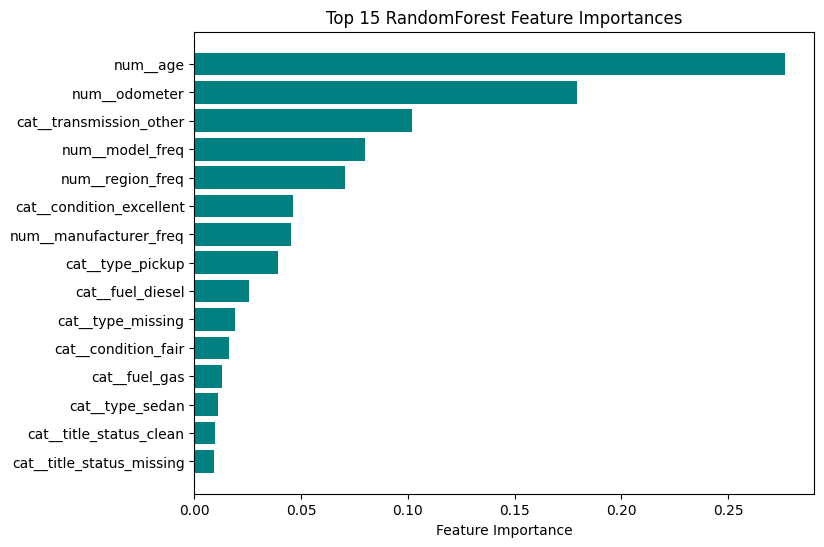

In [35]:
top_features = fi_df.sort_values("Importance", ascending=True).tail(15)

plt.figure(figsize=(8,6))
plt.barh(top_features["Feature"], top_features["Importance"], color="teal")
plt.xlabel("Feature Importance")
plt.title("Top 15 RandomForest Feature Importances")
plt.show()

# Summary
We built models to predict used car prices. After comparing Ridge Regression and Random Forests. **Random Forest without polynomial** features performed best with ~42% of price variation.

# Key Features to look for


*   **Age & Odometer** are strongest price drivers and (older/high-mileage cars lose value)
*   **Condition, Fuel Type, Transmission and Body Type** also influance price.
*   Clean titles add value.

# Deployment Plan
*  Deliver the Random Forest Model in a pipeline that takes car detials as input and output estimated market price.
*  Retrain regularly with new market data.

# Limitations
* Predictions are less accurate for luxuxry cars
* Sudden markt shocks (COVID) like supply chain interuptions are not captured.
